In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import joblib
import warnings


In [22]:
! pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [23]:
df = pd.read_csv('Maintenance.csv')
inspection_results = {
    'shape': df.shape,
    'dtypes': df.dtypes.to_dict(),
    'missing': df.isnull().sum().to_dict(),
    'duplicates': df.duplicated().sum()
}
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [24]:
inspection_results.values()

dict_values([(10000, 14), {'UDI': dtype('int64'), 'Product ID': dtype('O'), 'Type': dtype('O'), 'Air temperature [K]': dtype('float64'), 'Process temperature [K]': dtype('float64'), 'Rotational speed [rpm]': dtype('int64'), 'Torque [Nm]': dtype('float64'), 'Tool wear [min]': dtype('int64'), 'Machine failure': dtype('int64'), 'TWF': dtype('int64'), 'HDF': dtype('int64'), 'PWF': dtype('int64'), 'OSF': dtype('int64'), 'RNF': dtype('int64')}, {'UDI': 0, 'Product ID': 0, 'Type': 0, 'Air temperature [K]': 0, 'Process temperature [K]': 0, 'Rotational speed [rpm]': 0, 'Torque [Nm]': 0, 'Tool wear [min]': 0, 'Machine failure': 0, 'TWF': 0, 'HDF': 0, 'PWF': 0, 'OSF': 0, 'RNF': 0}, np.int64(0)])

In [25]:
eda_stats = df.describe().to_dict()
target_dist = df['Machine failure'].value_counts().to_dict()

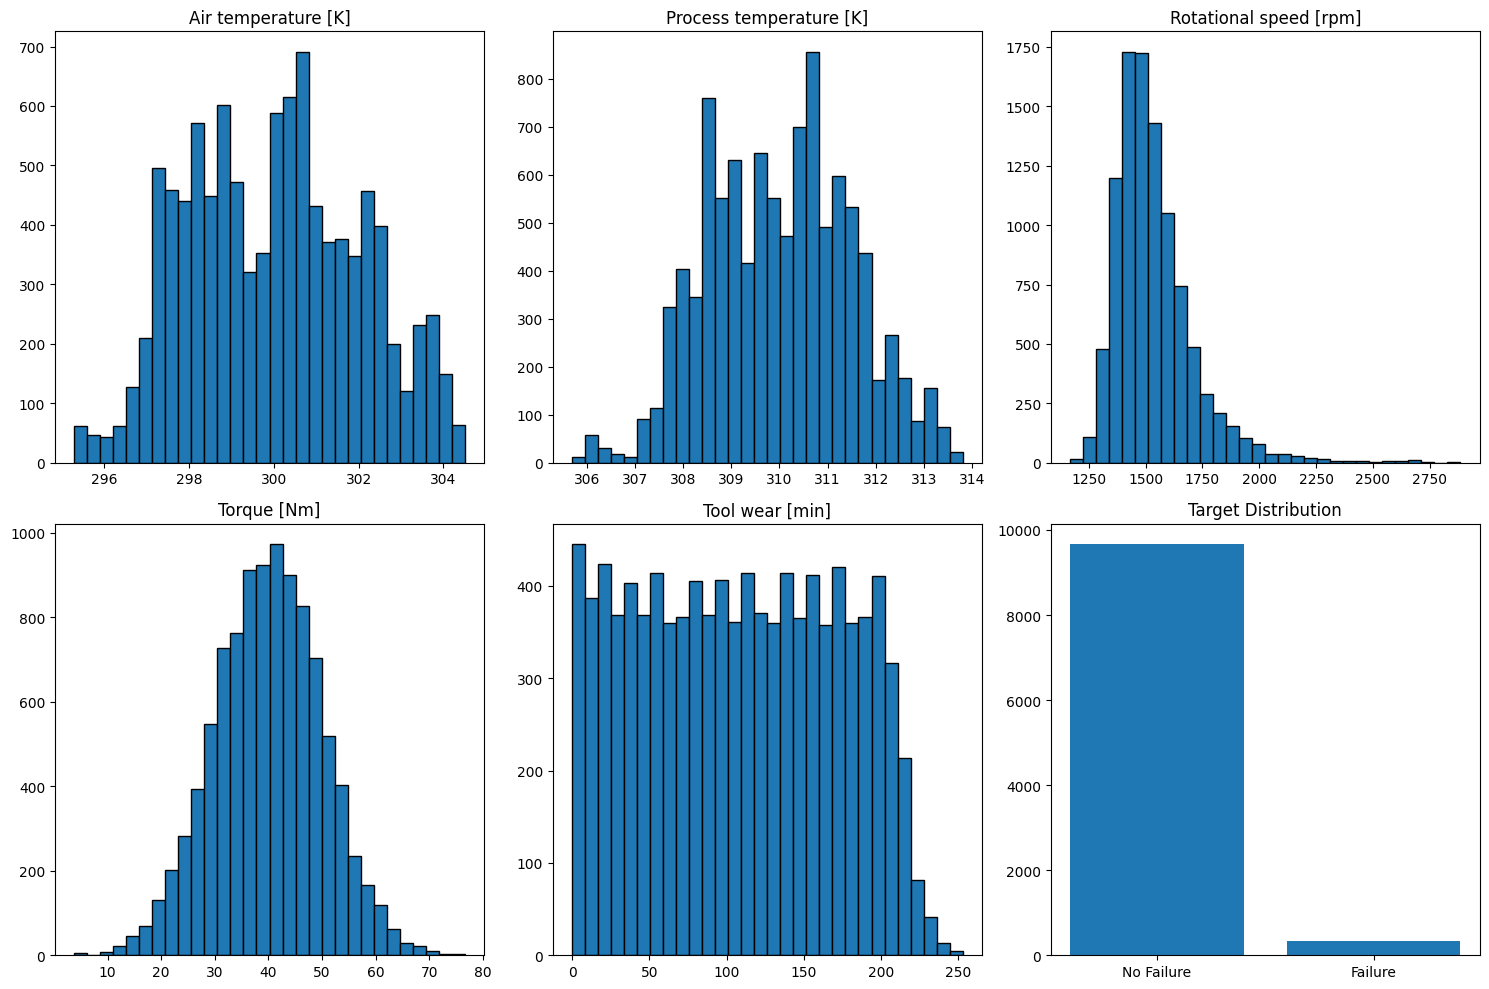

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
numeric_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
for idx, col in enumerate(numeric_cols):
    axes[idx//3, idx%3].hist(df[col], bins=30, edgecolor='black')
    axes[idx//3, idx%3].set_title(col)
axes[1, 2].bar(['No Failure', 'Failure'], df['Machine failure'].value_counts().values)
axes[1, 2].set_title('Target Distribution')
plt.tight_layout()
plt.savefig('eda_plots.png', dpi=300)


In [27]:

df['Energy_Indicator'] = (df['Torque [Nm]']**2) * df['Rotational speed [rpm]']


In [28]:
df = df.drop(columns=['UDI', 'Product ID'], errors='ignore')

In [29]:
if 'Type' in df.columns:
    le = LabelEncoder()
    df['Type_Encoded'] = le.fit_transform(df['Type'])
    df = df.drop('Type', axis=1)

X = df.drop(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, errors='ignore')
y = df['Machine failure']

numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




In [30]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

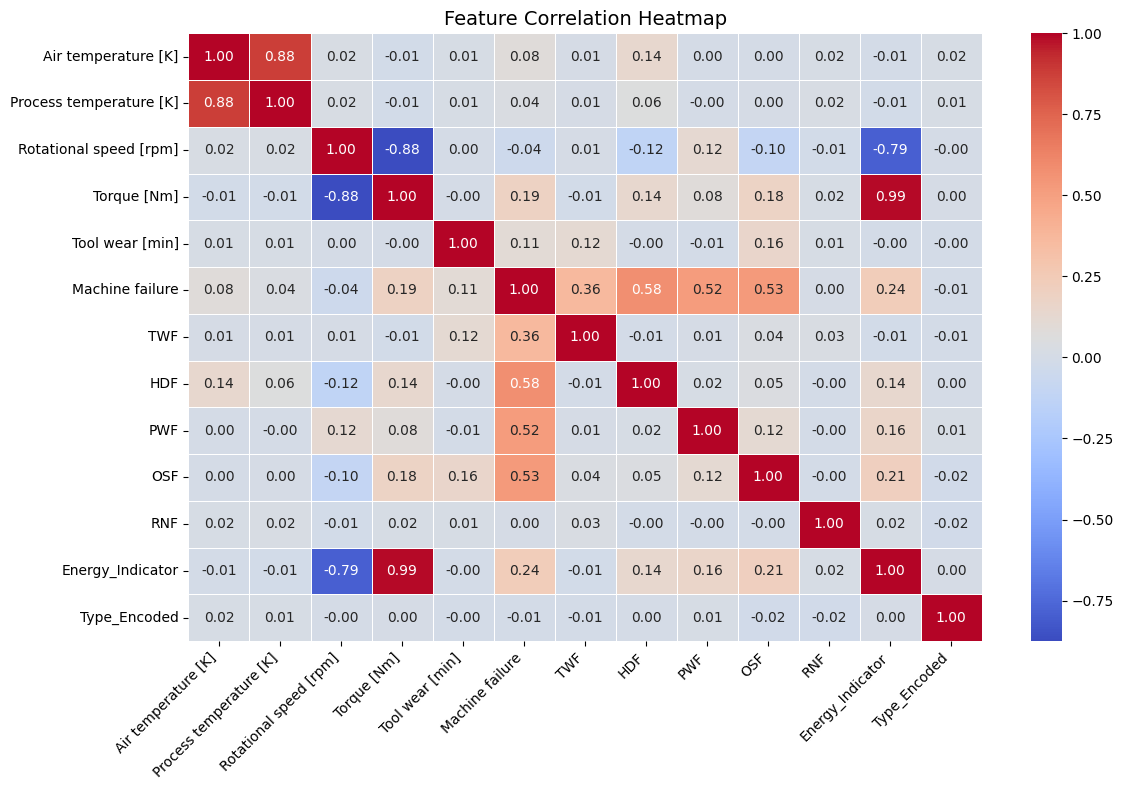

In [31]:
# Correlation heatmap (like your output)

import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar=True
)

plt.title("Feature Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
